In [2]:
import soundfile as sf
import matplotlib.pyplot as plt
import sounddevice as sd
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
from scipy.signal import find_peaks
from code_exercise1 import my_windowing, get_index_from_time, get_input_split_size, get_fundamental_frequency
from code_exercise2 import convert_to_samples, compute_stft, plot_spectrogram

threshold = 80
def load_audio(file_path: str) -> [np.ndarray, int]:
    """
    Load an audio file.

    :param file_path: path to the audio file
    :return: a tuple containing
        - the audio data
        - the sampling rate
    """
    return sf.read(file_path)
def compute_power(signal_segment: np.ndarray) -> float:
    """
    Compute the power of a signal segment.

    :param signal_segment: the signal segment
    :return: the power of the signal segment
    """
    return np.sum(signal_segment**2)

def compute_power_for_all_frames(m_frames: np.ndarray) -> np.ndarray:
    """
    Compute the power for all frames.

    :param m_frames: matrix containing the frames
    :return: a vector containing the power for all frames
    """
    return np.apply_along_axis(compute_power, 1, m_frames)

def count_zero_crossings(signal_segment: np.ndarray) -> np.ndarray:
    """
    Count the zero crossings in a signal segment.

    :param signal_segment: the signal segment
    :return: the number of zero crossings
    """
    return np.sum(np.where(signal_segment*np.roll(signal_segment, 1)<=0, 1, 0))

def is_voiced(signal_segments: np.ndarray) -> np.ndarray:
    """
    Check if a signal segment is voiced.

    :param signal_segment: the signal segment
    :return: 1 if the signal segment is voiced, 0 otherwise
    """

    return get_number_of_zero_crossings(signal_segments) < threshold

def get_number_of_zero_crossings(signal) -> np.ndarray:
    """
    Get the number of zero crossings for all frames.

    :param signal: the signal
    :return: a vector containing the number of zero crossings for all frames
    """
    return np.apply_along_axis(count_zero_crossings, 1, signal)

    


In [3]:
# 2.2.1
x, fs = load_audio('Audio/female8khz.wav')
N = 32
R = 8 #segment shift
L = N - R 
m_frames, v_time_frame = my_windowing(x, fs, N, R)
# Why do we segment the signal prior to analysis instead of processing the whole signal at once?
# -> more detailed: we want to detect the different vowels and consonants in the signal in time
# -> analyzing bigger segments needs more frequencies -> more data -> more computation time
# Is a segment length of 32 ms appropriate? Why or why not?
# -> convert_to_samples(32, fs) = 256 sampels 
# -> tradeoff between time resolution and frequency resolution
sd.play(x, fs)
sd.wait()


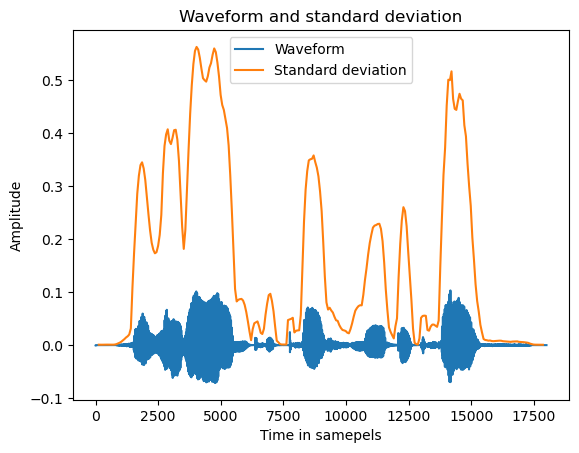

<Figure size 640x480 with 0 Axes>

In [4]:
# 2.2.2
# Compute the power of each frame
v_power = compute_power_for_all_frames(m_frames)
# standrad deviation
v_std = np.sqrt(v_power)
# plot waveform and v_std
plt.plot(x, label='Waveform')
plt.plot(get_index_from_time(v_time_frame/1000, fs), v_std, label='Standard deviation')
plt.title('Waveform and standard deviation')
plt.xlabel('Time in samepels')
plt.ylabel('Amplitude')
plt.legend()
plt.show()
plt.clf()

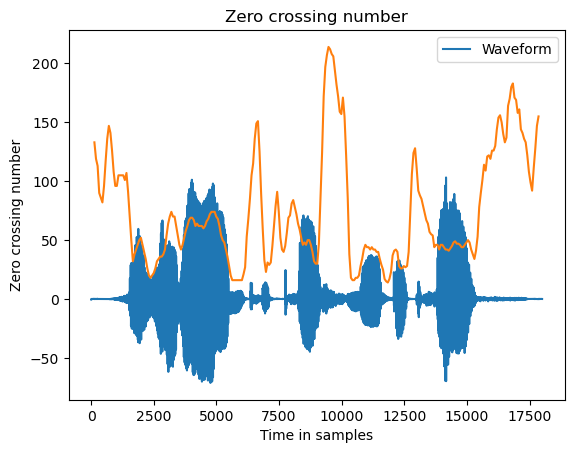

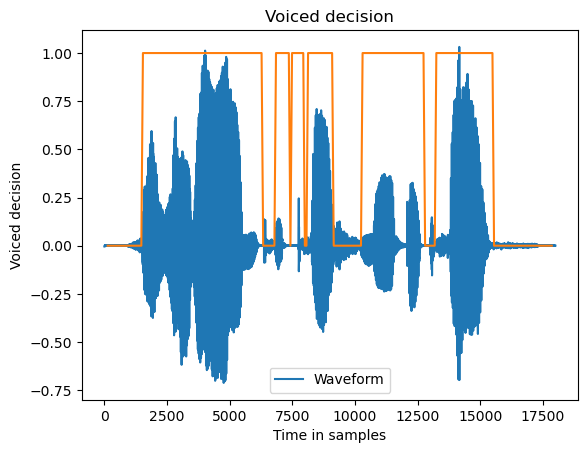

<Figure size 640x480 with 0 Axes>

In [5]:
# 2.2.3
# Explain differences in the creation of speech for voiced and unvoiced sounds.
# -> voiced sounds: vocal cords vibrate -> periodic signal, unvoiced sounds: turbulent airflow -> aperiodic signal aka noise (more zero crossings)
# Why might the number of zero crossings provide valuable information for the voiced/unvoiced decision?
# -> voiced sounds: less zero crossings, unvoiced sounds: more zero crossings
# Think of a way how you can efficiently detect a zero crossing between two samples. How can you realize that in Python?
# -> sample[i] * sample[i+1] < 0 oder ein schritt in der auto correlation: np.sum(np.sign(sample* sample.shift(1)))

zero_crossing_number = get_number_of_zero_crossings(m_frames)
plt.plot(x*1000, label='Waveform')
plt.plot(get_index_from_time(v_time_frame/1000, fs), zero_crossing_number)
plt.title('Zero crossing number')
plt.xlabel('Time in samples')
plt.ylabel('Zero crossing number')
plt.legend()
plt.show()
plt.clf()

# we threshold around 80 zero crossings

voiced_decision = is_voiced(m_frames)
plt.plot(x*10, label='Waveform')
plt.plot(get_index_from_time(v_time_frame/1000, fs), voiced_decision)
plt.title('Voiced decision')
plt.xlabel('Time in samples')
plt.ylabel('Voiced decision')
plt.legend()
plt.show()
plt.clf()

# In general: are all speech sounds eit2

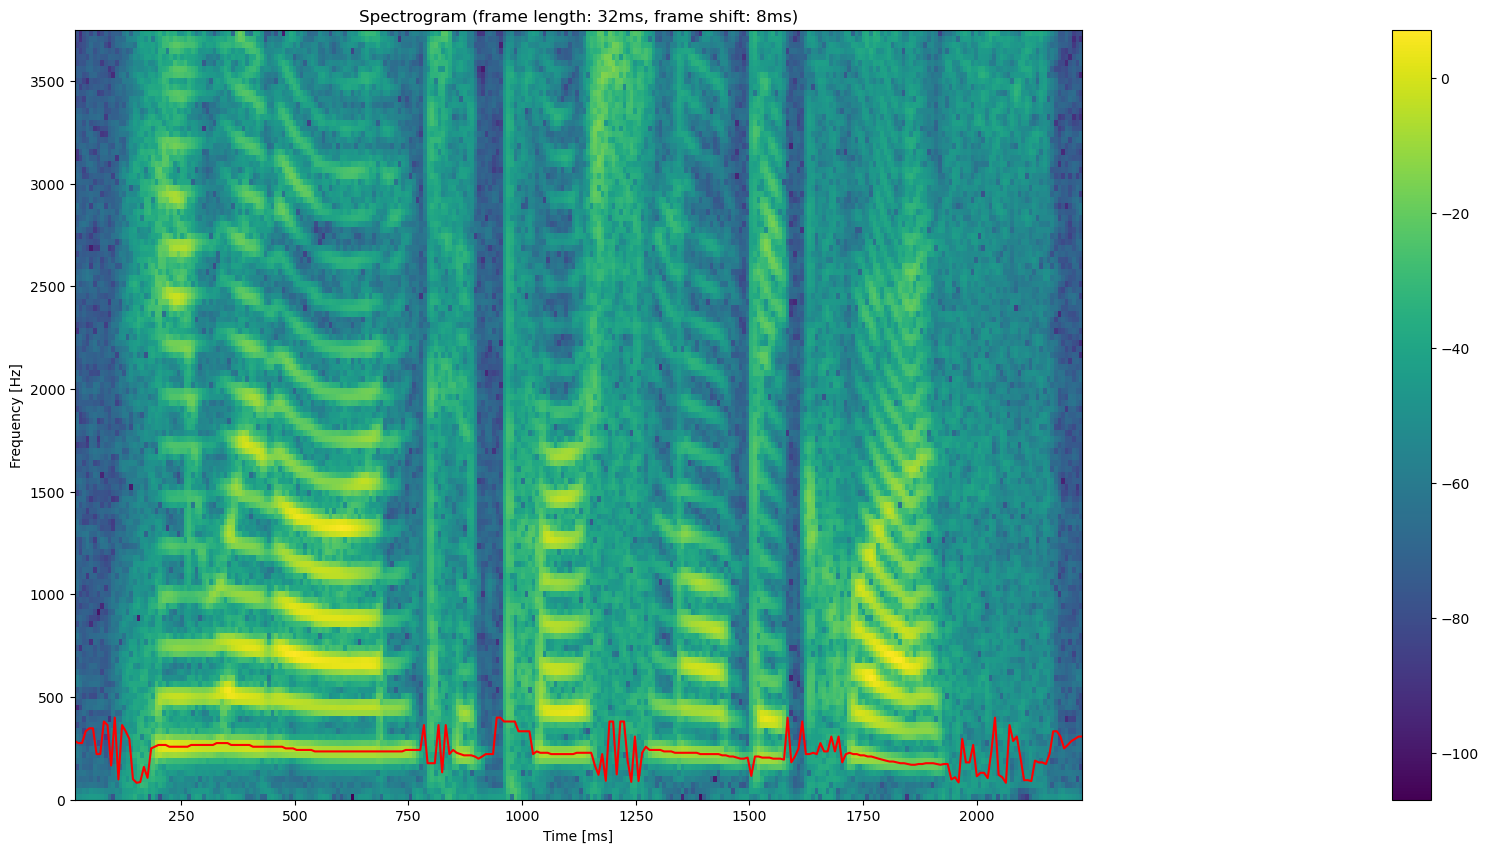

In [6]:
# 2.4.

def estimate_f0(m_frames: np.ndarray, fs: int) -> np.ndarray:
    return np.apply_along_axis(get_fundamental_frequency, 0, x, fs, N, R)


freq_estimate, v_time_frames = estimate_f0(m_frames, fs)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
plot_spectrogram(x, fs, N, R, ax=ax, fig=fig)
plt.plot(v_time_frames, freq_estimate, label='Fundamental frequency', color='r')

    
    

2.5

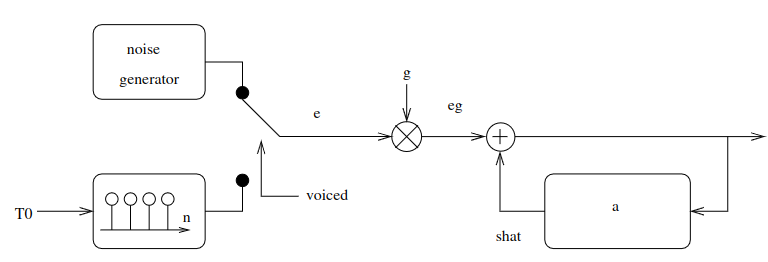

Voiced speech: Impulse train with Fundamental Period T_0
Unvoiced speech: random noise
-> This is our source signal e

After that the gain g ist multiplied (b_0 for the Filter).

Then the recursive Filter is added (a_i coefficients).

In [7]:
# 2.5
from code_exercise3 import compute_LP_coefficients

def compute_lpc(m_frames: np.ndarray, M: int):
    M_lpc = np.apply_along_axis(compute_LP_coefficients, 1, m_frames, M)
    assert M_lpc.shape == (m_frames.shape[0], M)
    return M_lpc

Choose a suitable model order M for linear prediction for a signal with an audio bandwidth of 4 kHz. 
Give reasons for your choice.
-> Slide 193: filter order = sampling frequency +2 , d.h. 8+2 = 10


In [8]:
def get_input_split_size(signal_length, sampling_rate, frame_length, frame_shift):
    frame_length_to_seconds = frame_length / 1000
    frame_length_to_ticks = get_index_from_time(frame_length_to_seconds, sampling_rate)
    frame_shift_to_seconds = frame_shift / 1000
    frame_shift_to_ticks = get_index_from_time(frame_shift_to_seconds, sampling_rate)
    # wir gucken, wie viele frame_shifts in das singal passsen, aber müssen aufpassen, dass es gross genug ist für die frame_length_to_ticks
    return (signal_length - frame_length_to_ticks) // frame_shift_to_ticks + 1

def get_unvoiced_signal(sampels: int):
    return np.random.rand(sampels)

from code_exercise1 import get_period_from_freq
def get_voiced_signal(sampels: int, fs: int = 8000, f0 : int =100, template=False):
    voiced_ex = np.zeros(sampels)
    if not template:
        voiced_ex[::get_period_from_freq(f0, fs)] = 1
    return voiced_ex

def segment_signal(signal: np.ndarray, R: int) -> np.ndarray:
    # Calculate the number of samples per segment
    segment_length = int(R * fs / 1000)  # Convert milliseconds to samples

    # Determine the total number of segments needed
    num_segments = len(signal) // segment_length

    # Truncate the signal to have an integer number of segments
    truncated_length = num_segments * segment_length
    signal_truncated = signal[:truncated_length]

    # Split the truncated signal into segments
    splits = np.array_split(signal_truncated, num_segments)

    # Verify that all segments have the same size
    assert all(len(segment) == segment_length for segment in splits), "Segments have different sizes"

    return splits

segmented_voiced = segment_signal(get_voiced_signal(len(x), fs), R)
segmented_unvoiced = segment_signal(get_unvoiced_signal(len(x)), R)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

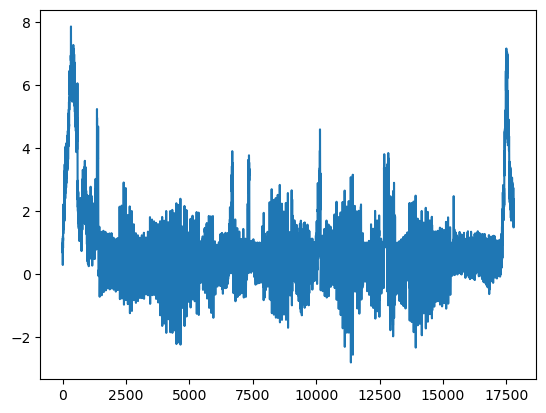

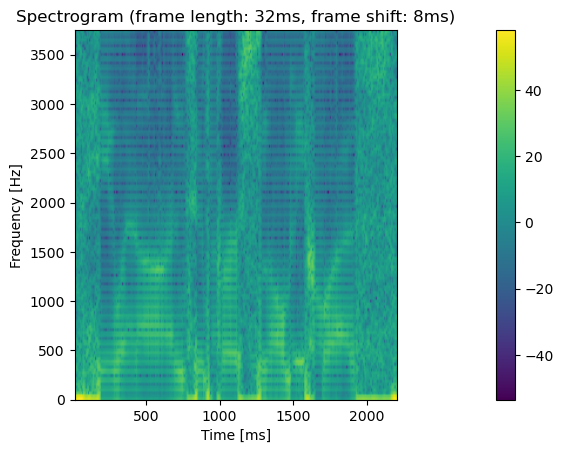

[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [9]:
from UploadCode.filteradaptively import filter_adaptively
def apply_LPC_to_voiced_unvoiced_e(segmented_voiced, segmented_unvoiced):
    LPCs = compute_lpc(m_frames, 10)
    segmented_voiced_output = []
    segmented_unvoiced_output = []
    segmented_combined_output = []
    filter_state_voiced = None
    filter_state_unvoiced = None
    for i in range(len(LPCs)):
        print(i)
        ar_coeff = np.concatenate(([1], LPCs[i]))
        segment = segmented_voiced[i] #if voiced_decision[i] else segmented_unvoiced[i]
        segment_out, filter_state_voiced = filter_adaptively(np.array([1]), ar_coeff, segment, filter_state_voiced)
        segmented_voiced_output.append(segment_out)
        segment = segmented_unvoiced[i]
        segment_out, filter_state_unvoiced = filter_adaptively(np.array([1]), ar_coeff, segment, filter_state_unvoiced)
        segmented_unvoiced_output.append(segment_out)

        if is_voiced(np.array([m_frames[i]])):
            segmented_combined_output.append(segmented_voiced_output[-1])
        else:
            segmented_combined_output.append(segmented_unvoiced_output[-1])
    return np.concatenate(segmented_voiced_output), np.concatenate(segmented_unvoiced_output), np.concatenate(segmented_combined_output)

segmented_voiced_output, segmented_unvoiced_output, segmented_combined_output = apply_LPC_to_voiced_unvoiced_e(segmented_voiced, segmented_unvoiced)
    

# plt.plot(segmented_voiced_output)
sd.play(segmented_voiced_output, fs)
sd.wait()
# plot_spectrogram(segmented_voiced_output, fs, 32, R)
# #sleep(2)
# plt.plot(segmented_unvoiced_output)
# #sd.play(segmented_unvoiced_output, fs)
# plot_spectrogram(segmented_unvoiced_output, fs, 32, R)
plt.plot(segmented_combined_output)
# sd.play(segmented_combined_output, fs)
# sd.wait()
plot_spectrogram(segmented_combined_output, fs, 32, R)
segment_signal(get_voiced_signal(len(x), fs), R)

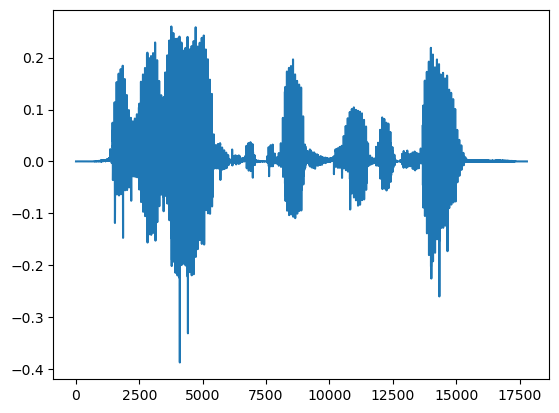

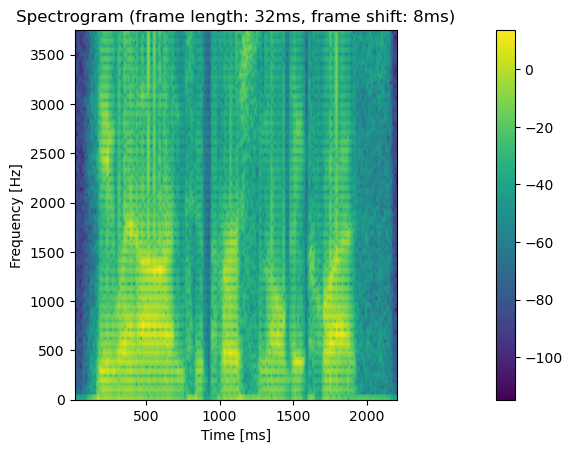

In [10]:
# 3.3
# we have compute power and compute_power_for_all_frames previously defined
def add_gain_to_LPC_signal(segments: np.ndarray):
    original_power = compute_power_for_all_frames(m_frames)
    segment_power = compute_power_for_all_frames(segments)
    #  we want to find x, so that segment*x = gain <=> x = gain/segment
    factors = np.sqrt(original_power/segment_power)
    # apply the factors to the segments
    segmented_combined_output = segments * factors[:, np.newaxis]
    return segmented_combined_output

def apply_LPC_to_voiced_unvoiced_e(segmented_voiced, segmented_unvoiced, add_gain=True, use_LPC=True):
    LPCs = compute_lpc(m_frames, 10)
    segmented_voiced_output = []
    segmented_unvoiced_output = []
    segmented_combined_output = []
    filter_state_voiced = None
    filter_state_unvoiced = None
    for i in range(len(LPCs)):
        if use_LPC:
            ar_coeff = np.concatenate(([1], LPCs[i]))
            segment = segmented_voiced[i] #if voiced_decision[i] else segmented_unvoiced[i]

            segment_out, filter_state_voiced = filter_adaptively(np.array([1]), ar_coeff, segment, filter_state_voiced)

            segmented_voiced_output.append(segment_out)
            segment = segmented_unvoiced[i]
            segment_out, filter_state_unvoiced = filter_adaptively(np.array([1]), ar_coeff, segment, filter_state_unvoiced)

            segmented_unvoiced_output.append(segment_out)
        else:
            segmented_voiced_output.append(segmented_voiced[i])
            segmented_unvoiced_output.append(segmented_unvoiced[i])

        if is_voiced(np.array([m_frames[i]])):
            segmented_combined_output.append(segmented_voiced_output[-1])
        else:
            segmented_combined_output.append(segmented_unvoiced_output[-1])
    if add_gain:
        segmented_combined_output = add_gain_to_LPC_signal(np.vstack(segmented_combined_output))
        segmented_voiced_output = add_gain_to_LPC_signal(np.vstack(segmented_voiced_output))
        segmented_unvoiced_output = add_gain_to_LPC_signal(np.vstack(segmented_unvoiced_output))
        

    return np.concatenate(segmented_voiced_output), np.concatenate(segmented_unvoiced_output), np.concatenate(segmented_combined_output)

_, __, segmented_combined_output_concat_with_gain = apply_LPC_to_voiced_unvoiced_e(segmented_voiced, segmented_unvoiced)
plt.plot(segmented_combined_output_concat_with_gain)
plot_spectrogram(segmented_combined_output_concat_with_gain, fs, 32, R)
plt.show()
sd.play(segmented_combined_output_concat_with_gain, fs)
sd.wait()
# What is the improvement? -> noise inbetwe, m_framesen gets much lower, so you can hear it more clearly


/tmp/ipykernel_4990/573776201.py:7: RuntimeWarning: divide by zero encountered in divide
  factors = np.sqrt(original_power/segment_power)
/tmp/ipykernel_4990/573776201.py:9: RuntimeWarning: invalid value encountered in multiply
  segmented_combined_output = segments * factors[:, np.newaxis]


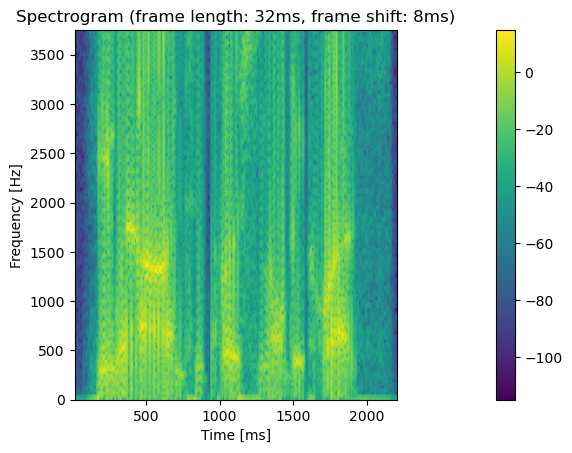

In [11]:
# 3.4
def use_voiced_signal_for_voiced_segments(x: np.ndarray, fs: int, R: int, N: int) -> np.ndarray:
    """
    Process and modify the voiced segments of the signal.
    
    :param x: Input signal
    :param fs: Sampling frequency
    :param R: Frame shift
    :param N: Frame length
    :return: Modified voiced segments
    """
    segmented_voiced = segment_signal(get_voiced_signal(len(x), fs, template=True), R)
    fundamental_periods, _ = get_fundamental_frequency(x, fs, N, R)
    counter = 0
    #assert len(fundamental_periods) == len(segmented_voiced), f"fundamental period: {len(fundamental_periods)}, segmented_voiced: {len(segmented_voiced)}"
    for j, frame in enumerate(segmented_voiced):
        for i in range(len(frame)):
            counter += 1
            if len(fundamental_periods)>j and counter > fundamental_periods[j]:
                counter = 0
                segmented_voiced[j][i] = 1
    return segmented_voiced

segmented_voiced_with_f = use_voiced_signal_for_voiced_segments(x, fs, R, N)

segmented_voiced_with_f, segmented_unvoiced_with_f, segmented_combined_output_with_f = apply_LPC_to_voiced_unvoiced_e(segmented_voiced_with_f, segmented_unvoiced, add_gain=True)

plot_spectrogram(segmented_combined_output_with_f, fs, 32, R)
plt.show()
sd.play(segmented_combined_output_with_f, fs)
sd.wait()

    
        

Listen to the resulting signal. Does the signal quality improve?
-> Idk, it gets very quiet.
Now that we incorporated all of our parameters, do you still hear artifacts or errors in the synthesized speech
signal? If this is the case, try to find and explain reasons for that
-> Seems like we did something wrong because it does not sound too realistic.
Display the spectrogram of the synthesized signal, compare it to the one of the last section, and explain differences.
-> I do not see differences.

3.5 - No LPC
___________
Intuitively, how does leaving out the LPC synthesize step influence the spectrum of the signal?
-> Vowels vs fricatives should still be distinguishable, but it is as if a human would not use their tongue to speak

/tmp/ipykernel_4990/573776201.py:7: RuntimeWarning: divide by zero encountered in divide
  factors = np.sqrt(original_power/segment_power)
/tmp/ipykernel_4990/573776201.py:9: RuntimeWarning: invalid value encountered in multiply
  segmented_combined_output = segments * factors[:, np.newaxis]


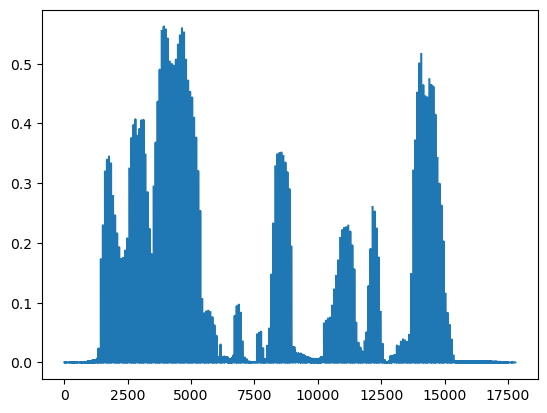

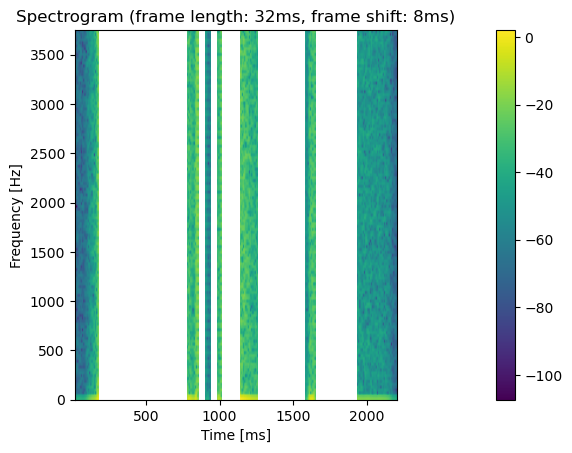

In [12]:
_, __, no_LPC_segmented_combined_output = apply_LPC_to_voiced_unvoiced_e(segmented_voiced, segmented_unvoiced, use_LPC=False)
plt.plot(no_LPC_segmented_combined_output)
plot_spectrogram(no_LPC_segmented_combined_output, fs, 32, R)
plt.show()
sd.play(no_LPC_segmented_combined_output, fs)
sd.wait()


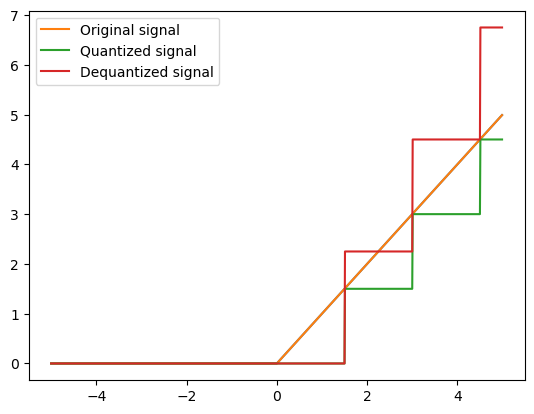

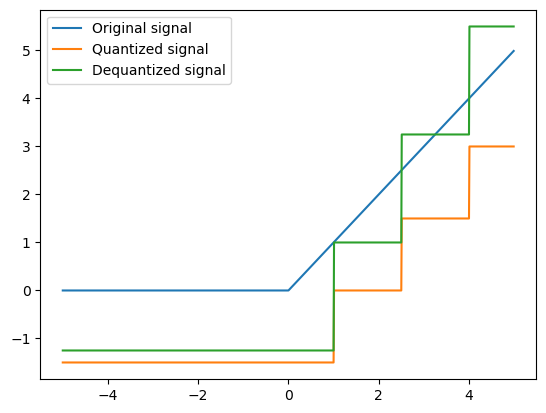

In [22]:
def quantize_encoder(x: np.ndarray , num_bits: int , x_range: float , x_center: float):
    """
    Quantize a signal using a uniform quantizer.

    :param x: the signal to be quantized
    :param num_bits: the number of bits to use for quantization
    :param x_range: the range of the signal
    :param x_center: the center of the signal
    :return: the quantized signal
    """
    # Calculate the step size
    step_size = x_range / (2**num_bits)
    return step_size * np.floor((x - x_center) / step_size ) 

def quantize_decoder(x_quantized: np.ndarray , num_bits: int , x_range: float , x_center: float):
    """
    Decode a quantized signal using a uniform quantizer.

    :param x_quantized: the quantized signal
    :param num_bits: the number of bits used for quantization
    :param x_range: the range of the signal
    :param x_center: the center of the signal
    :return: the decoded signal
    """
    # Calculate the step size
    step_size = x_range / (2**num_bits)
    return x_quantized * step_size + x_center

n = np.arange(-5, 5, 0.01)
y = []
for i in range(len(n)):
    temp = (n[i] if n[i]>=0 else 0)
    y.append(temp)
plt.plot(n, y) # kp, wie die genau aussehen soll.

test_signal = np.array(y)
quantized_signal = quantize_encoder(test_signal, 2, 6, 0)
dequantized_signal = quantize_decoder(quantized_signal, 2, 6, 0)

plt.plot(n, test_signal, label='Original signal')
plt.plot(n, quantized_signal, label='Quantized signal')
plt.plot(n, dequantized_signal, label='Dequantized signal')
plt.legend()
plt.show()

quantized_singla_1 = quantize_encoder(test_signal, 2, 6, 1)
dequantized_signal_1 = quantize_decoder(quantized_singla_1, 2, 6, 1)

plt.plot(n, test_signal, label='Original signal')
plt.plot(n, quantized_singla_1, label='Quantized signal')
plt.plot(n, dequantized_signal_1, label='Dequantized signal')
plt.legend()
plt.show()

-How many quantization levels (or indices) can you realize with n Bits? -> 2^n
-Lets assume you have an input signal with values ranging from -2 to 2 and you choose x_range = 4, and num_bits
= 2. How should you choose x_center? What are the expected quantization levels? The step size between two
quantization levels?
Da x_range =4, ist das intervall [-2, 2], x_center sollte in der mitte liegen, also 0 sein. Wir haben 4 quantization levels, wo liegen sie? keine Ahnung.

4.2 Quantizing the fundamental frequency
_______________________________
a) How do you choose x_range and x_center based on the maximum and minimum fundamental frequency used in the
estimation process (Section 2)? -> Man kann sich max und min angucken, die differenz daraus ist die range. Und center ist dann die mitte?

In [ ]:
# 4.2
